# Imports

In [1]:
import torch
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt

from torch import Tensor
from torch import optim
from torch.nn import functional as F

import dlc_practical_prologue as prologue

%matplotlib inline

# Load data

Data: pairs of 14x14 grayscale images w/ train and test 1000 pairs each (-> N = 1000) <br />
-> input N x 2 x 14 x 14 <br />
-> target N <br />
-> classes N x 2 <br />

In [2]:
# generate 2000 pairs of 14x14 grayscale images
N = 1000
dataset = prologue.generate_pair_sets(2*N)

In [3]:
# create train set from data set + verify size
train_input = dataset[0][0:N]
print(train_input.size())
train_target = dataset[1][0:N]
print(train_target.size())
train_classes = dataset[2][0:N]
print(train_classes.size())

torch.Size([1000, 2, 14, 14])
torch.Size([1000])
torch.Size([1000, 2])


In [4]:
# create test set from data set + check size
test_input = dataset[0][N:]
print(test_input.size())
test_target = dataset[1][N:]
print(test_target.size())
test_classes = dataset[2][N:]
print(test_classes.size())

torch.Size([1000, 2, 14, 14])
torch.Size([1000])
torch.Size([1000, 2])


# Normalize data 

(maybe use transforms.Normalize() instead later)

In [5]:
def normalize(train_input):
    mu, std = train_input.mean(), train_input.std()
    train_input_norm = train_input.sub_(mu).div_(std)
    test_input_norm = test_input.sub_(mu).div_(std)
    return train_input_norm, test_input_norm

In [6]:
# normalize train_input and test_input + check size
train_input_norm, test_input_norm = normalize(train_input)
print(train_input_norm.size())
print(test_input_norm.size())

torch.Size([1000, 2, 14, 14])
torch.Size([1000, 2, 14, 14])


# Separate pairs into two train sets

In [7]:
# separate the pairs in 2 train_inputs + check size
train_input_first = train_input_norm[:,0:1,:,:]
train_input_sec = train_input_norm[:,1:,:,:]
print(train_input_first.size())
print(train_input_sec.size())

torch.Size([1000, 1, 14, 14])
torch.Size([1000, 1, 14, 14])


In [8]:
# same with their class (digits classes)
train_classes_first = train_classes[:,0:1]
train_classes_sec = train_classes[:,1:]
print(train_classes_first.size())
print(train_classes_sec.size())

torch.Size([1000, 1])
torch.Size([1000, 1])


# Try models

2 parts: <br />
1) classify the digits of the pair -> classes 0 to 9 -> try a LeNet <br /> 
2) compare the 2 digits: if 1st <= 2nd -> class 1, else class 0

### LeNet

In [9]:
# just to test dimensions in the Net
train_input = train_input_first
train_target = train_classes_first.squeeze()
print(train_input.size())
print(train_target.size())

torch.Size([1000, 1, 14, 14])
torch.Size([1000])


In [10]:
# define the network
class Net(nn.Module):
    def __init__(self, nb_hidden):
        super(Net, self).__init__()
        # start with 1x14x14
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3) # after that 32x12x12
        self.conv2 = nn.Conv2d(32, 64, kernel_size=1) # after that 64x4x4
        self.fc1 = nn.Linear(256, nb_hidden)
        self.fc2 = nn.Linear(nb_hidden, 10)
    def forward(self, x):
        #print(x.size())
        #print(self.conv1(x).size())
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size = 3)) # after that 32x4x4
        #print(x.size())
        #print(self.conv2(x).size())
        x = F.relu(F.max_pool2d(self.conv2(x), kernel_size = 2)) # after that 64x2x2
        #print(x.size())
        #x = x.view(x.size(0), -1)
        x = x.view(-1, 256)
        #print(x.size())
        x = F.relu(self.fc1(x))
        #print(x.size())
        x = self.fc2(x)
        #print(x.size())
        return x

In [11]:
def train_model(model, train_input, train_target, nb_epochs, lr, mini_batch_size):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr = lr)
    
    losses = []

    for e in range(nb_epochs):
        for b in range(0, train_input.size(0), mini_batch_size):
            output = model(train_input.narrow(0, b, mini_batch_size))
            loss = criterion(output, train_target.narrow(0, b, mini_batch_size))
            losses.append(loss)
            model.zero_grad()
            loss.backward()
            optimizer.step()
            
    plt.plot(losses)
    plt.ylabel('loss')

batch size = number of samples processed before the model is updated <br /> 
number of epochs = number of complete passes through the training dataset

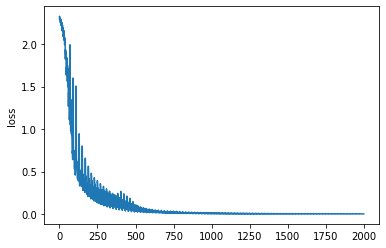

In [12]:
lr, nb_epochs, mini_batch_size = 1e-1, 100, 50

model = Net(200)

train_model(model, train_input, train_target, nb_epochs, lr, mini_batch_size)